# 1.5b: Logit Distribution Visualization

This notebook visualizes the full distribution of logit scores (dot products) for all tokens with respect to a reference hidden state.

## The Question

We found in 1.5a that 3,281 tokens share the same logit score for our simulated hidden state. But what does the **full distribution** look like?

We'll examine:
1. **Rank plot**: Tokens sorted by logit, showing the distribution curve
2. **Index plot**: Logits in vocabulary order, revealing any token-ID structure

This reveals how bfloat16 quantization discretizes the logit space into bins.

## Parameters

In [1]:
# Model to analyze
MODEL_NAME = "Qwen3-4B-Instruct-2507"

# Visualization
FIGSIZE = (14, 6)
DPI = 200
POINT_SIZE = 1
POINT_ALPHA = 0.5

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file
from pathlib import Path

## Load Equivalence Class Results

We'll load the reference hidden state from 1.5a and recompute dot products for all tokens.

In [3]:
# Load equivalence class metadata
equiv_path = Path(f"../tensors/{MODEL_NAME}/1.5a_logit_equivalence.safetensors")
equiv_data = load_file(equiv_path)

equiv_mask = equiv_data["equiv_mask"].bool()
equiv_dot = equiv_data["equiv_dot_product"].item()
n_equiv = equiv_data["n_equiv_members"].item()
ref_lat = equiv_data["ref_lat"].item()
ref_lon = equiv_data["ref_lon"].item()
ref_dist = equiv_data["ref_dist"].item()

print(f"Loaded equivalence class metadata:")
print(f"  Reference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°, dist={ref_dist:.6f}")
print(f"  Equivalence class size: {n_equiv:,} tokens")
print(f"  Equivalence class dot product: {equiv_dot:.8f}")

Loaded equivalence class metadata:
  Reference: lat=-7.288°, lon=6.941°, dist=0.371094
  Equivalence class size: 3,281 tokens
  Equivalence class dot product: 0.11621094


## Recompute All Dot Products

We need to recompute dot products for all tokens to visualize the full distribution.

In [4]:
print("\nRecomputing dot products for all tokens...\n")

# Detect device
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

# Load W
W_path = Path(f"../tensors/{MODEL_NAME}/W.safetensors")
W_bf16 = load_file(W_path)["W"]
N, d = W_bf16.shape

# Convert to float32 for PCA
W = W_bf16.to(torch.float32)

# Compute PCA (same as 1.5a)
W_centered = W - W.mean(dim=0)
cov = (W_centered.T @ W_centered) / N
eigenvalues, eigenvectors = torch.linalg.eigh(cov)
idx = torch.argsort(eigenvalues, descending=True)
eigenvectors = eigenvectors[:, idx]

# Define basis (same as 1.5a)
def get_pc_vector(pcs, index):
    pc_num = abs(index) - 1
    vector = pcs[:, pc_num].clone()
    if index < 0:
        vector = -vector
    return vector

NORTH_PC = 2
MERIDIAN_PC = 1
EQUINOX_PC = 3

north = get_pc_vector(eigenvectors, NORTH_PC)
meridian = get_pc_vector(eigenvectors, MERIDIAN_PC)
equinox = get_pc_vector(eigenvectors, EQUINOX_PC)

# Reconstruct hidden state from lat/lon/dist
lat_rad = np.deg2rad(ref_lat)
lon_rad = np.deg2rad(ref_lon)

x = np.cos(lat_rad) * np.cos(lon_rad)
y = np.cos(lat_rad) * np.sin(lon_rad)
z = np.sin(lat_rad)

direction = x * meridian + y * equinox + z * north
direction = direction / direction.norm()
h = direction * ref_dist

# Compute dot products in bfloat16
h_bf16 = h.to(torch.bfloat16).to(device)
W_bf16_device = W_bf16.to(device)

with torch.no_grad():
    dot_products = W_bf16_device @ h_bf16

dot_products = dot_products.to(torch.float32).cpu().numpy()

print(f"✓ Computed dot products for {N:,} tokens")
print(f"  Range: [{dot_products.min():.6f}, {dot_products.max():.6f}]")
print(f"  Mean: {dot_products.mean():.6f}")
print(f"  Median: {np.median(dot_products):.6f}")


Recomputing dot products for all tokens...

✓ Computed dot products for 151,936 tokens
  Range: [-0.283203, 0.257812]
  Mean: 0.091967
  Median: 0.099121


## Rank Plot: Sorted Logits

This shows the distribution curve when tokens are sorted by logit score.


Creating rank plot...



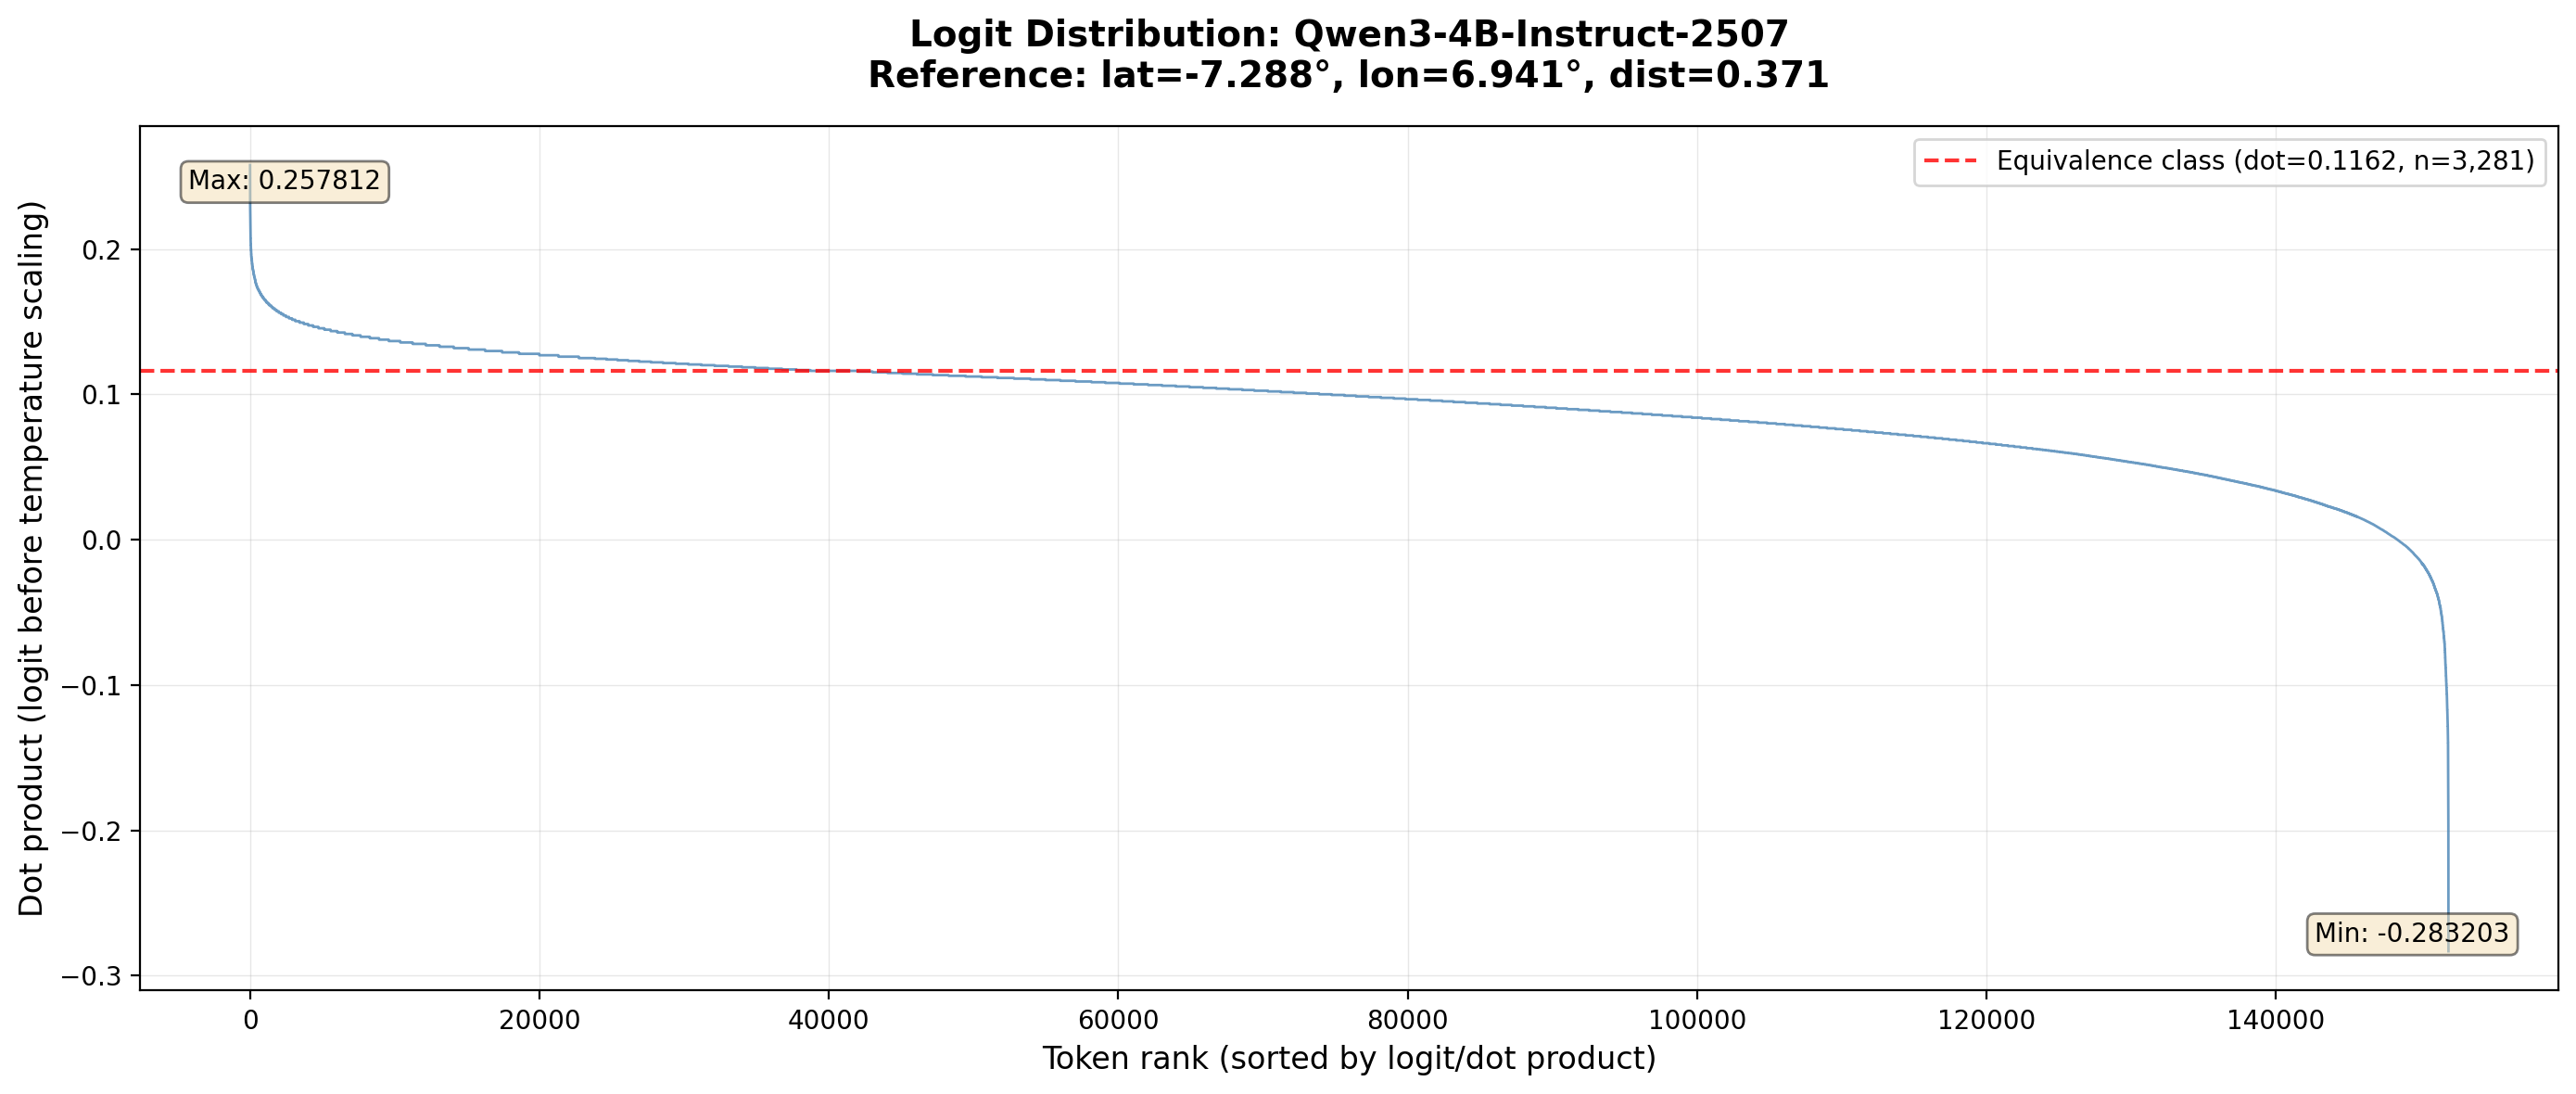

✓ Rank plot complete


In [5]:
print("\nCreating rank plot...\n")

# Sort dot products (descending)
sorted_dots = np.sort(dot_products)[::-1]
ranks = np.arange(N)

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Plot sorted dot products
ax.plot(ranks, sorted_dots, linewidth=1, color='steelblue', alpha=0.8)

# Highlight equivalence class dot product
ax.axhline(equiv_dot, color='red', linestyle='--', linewidth=1.5, 
           label=f'Equivalence class (dot={equiv_dot:.4f}, n={n_equiv:,})', alpha=0.8)

# Formatting
ax.set_xlabel('Token rank (sorted by logit/dot product)', fontsize=12)
ax.set_ylabel('Dot product (logit before temperature scaling)', fontsize=12)
ax.set_title(f'Logit Distribution: {MODEL_NAME}\n'
             f'Reference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°, dist={ref_dist:.3f}',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.legend(loc='upper right', fontsize=10)

# Add annotations for key regions
ax.text(0.02, 0.95, f'Max: {sorted_dots[0]:.6f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.text(0.98, 0.05, f'Min: {sorted_dots[-1]:.6f}',
        transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
        horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Rank plot complete")

## Index Plot: Logits in Vocabulary Order

This shows whether there's any structure in token ID space.


Creating index plot...



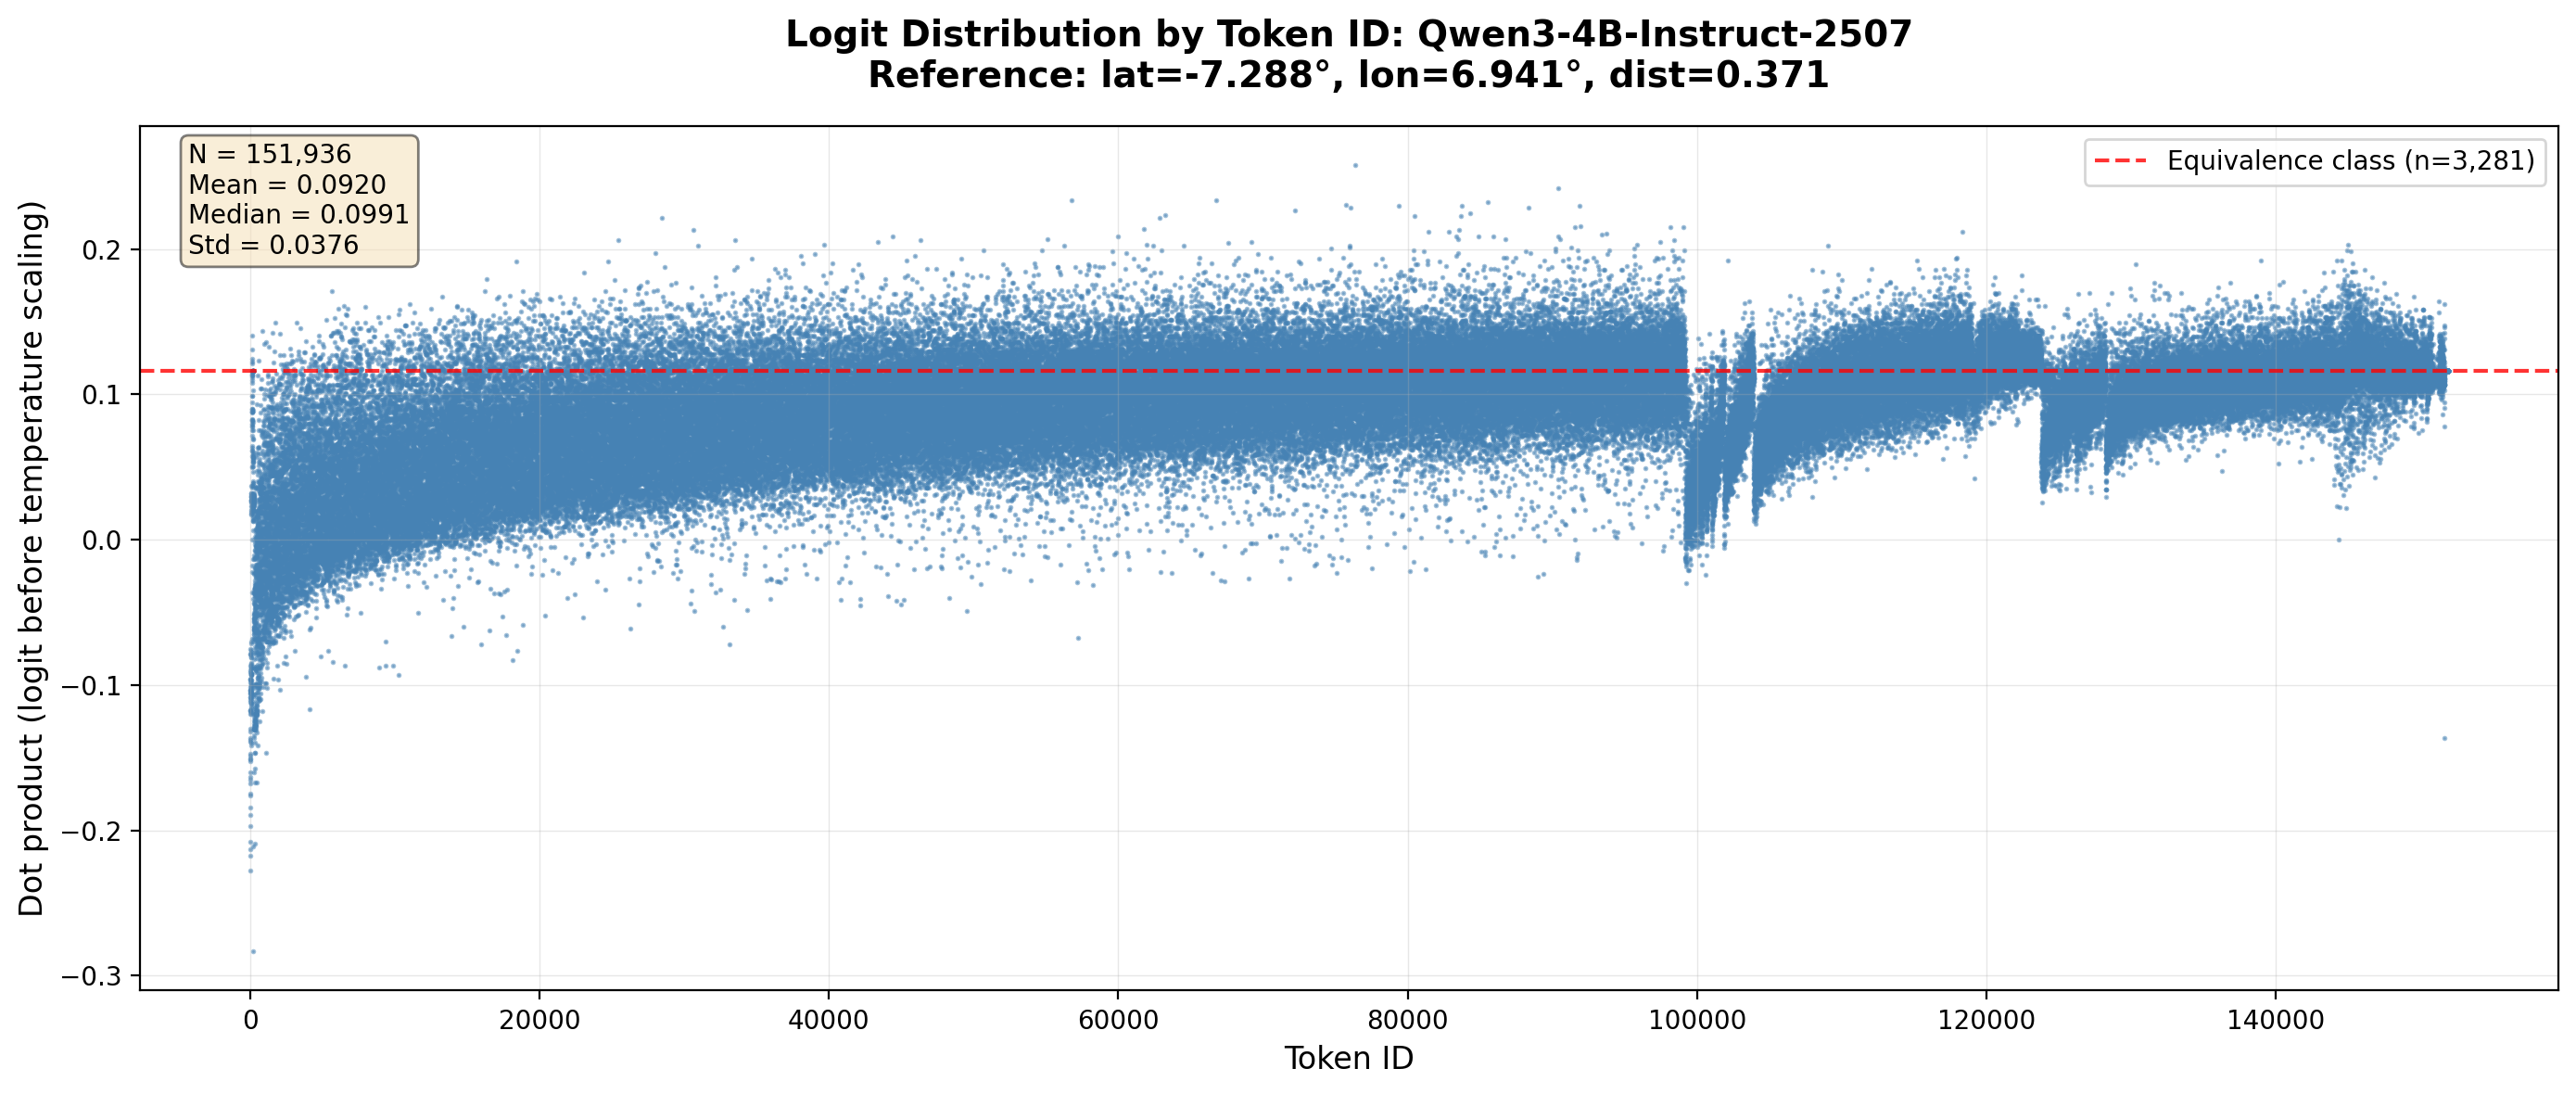

✓ Index plot complete


In [6]:
print("\nCreating index plot...\n")

# Token indices
token_ids = np.arange(N)

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Plot dot products by token ID
ax.scatter(token_ids, dot_products, s=POINT_SIZE, alpha=POINT_ALPHA, 
           color='steelblue', rasterized=True)

# Highlight equivalence class dot product
ax.axhline(equiv_dot, color='red', linestyle='--', linewidth=1.5, 
           label=f'Equivalence class (n={n_equiv:,})', alpha=0.8)

# Formatting
ax.set_xlabel('Token ID', fontsize=12)
ax.set_ylabel('Dot product (logit before temperature scaling)', fontsize=12)
ax.set_title(f'Logit Distribution by Token ID: {MODEL_NAME}\n'
             f'Reference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°, dist={ref_dist:.3f}',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linewidth=0.5)
ax.legend(loc='upper right', fontsize=10)

# Add statistics
stats_text = f"N = {N:,}\nMean = {dot_products.mean():.4f}\nMedian = {np.median(dot_products):.4f}\nStd = {dot_products.std():.4f}"
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Index plot complete")

## Histogram: Logit Value Distribution

This shows where logits pile up in value space (the bfloat16 quantization bins).


Creating histogram...



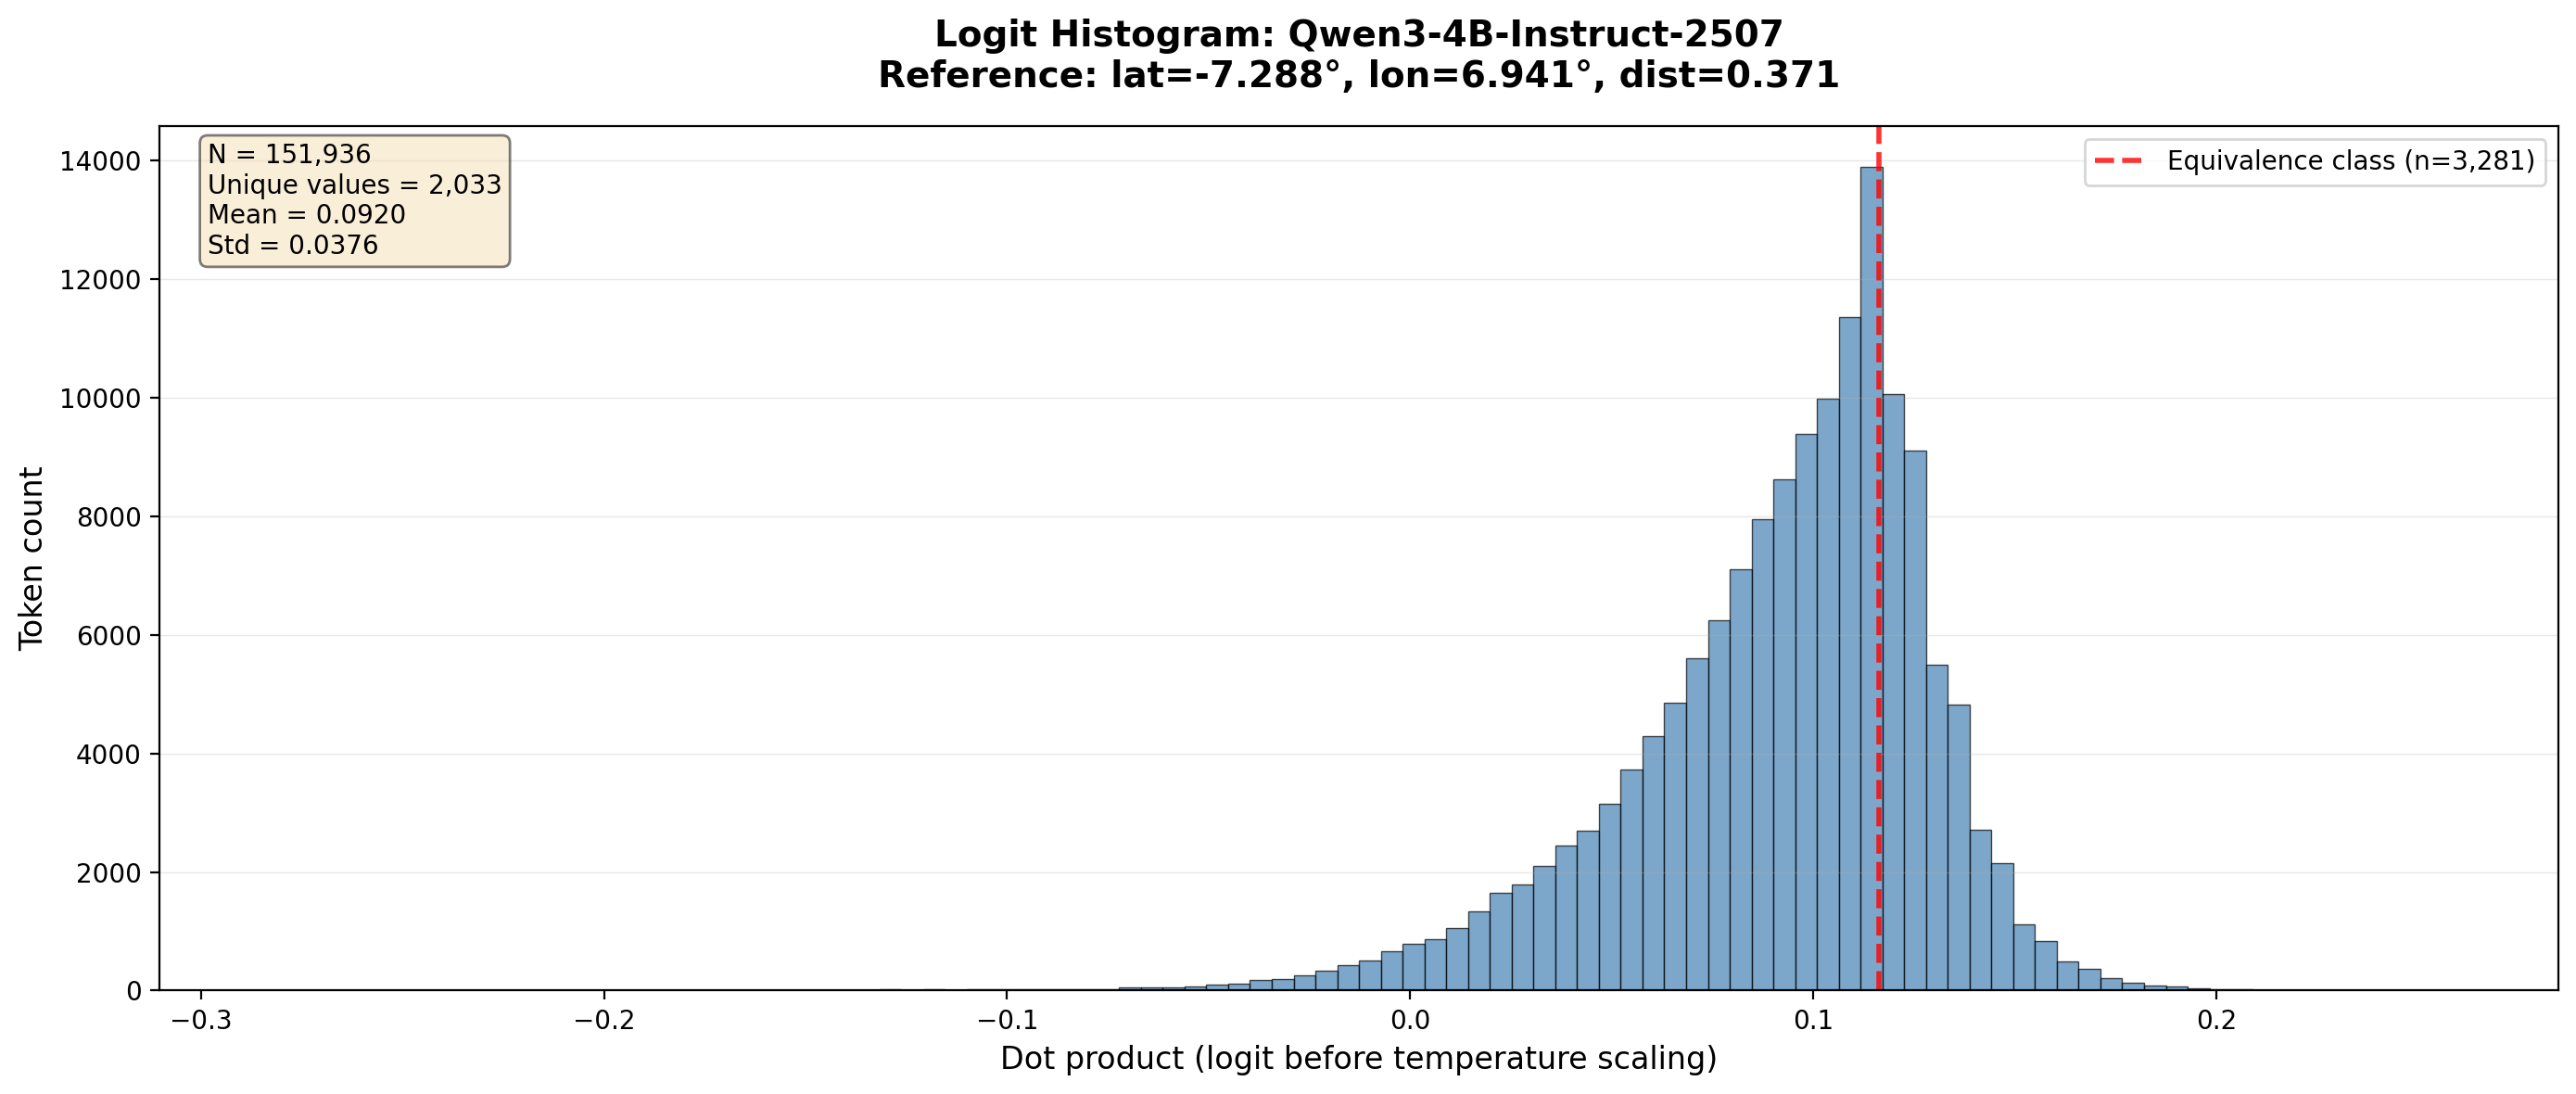

✓ Histogram complete


In [7]:
print("\nCreating histogram...\n")

# Create figure
fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)

# Plot histogram (use number of unique values as bins, capped at 100)
unique_dots = np.unique(dot_products)
n_bins = min(100, len(unique_dots))

counts, bins, patches = ax.hist(dot_products, bins=n_bins, color='steelblue', 
                                 alpha=0.7, edgecolor='black', linewidth=0.5)

# Highlight equivalence class dot product
ax.axvline(equiv_dot, color='red', linestyle='--', linewidth=2,
           label=f'Equivalence class (n={n_equiv:,})', alpha=0.8)

# Formatting
ax.set_xlabel('Dot product (logit before temperature scaling)', fontsize=12)
ax.set_ylabel('Token count', fontsize=12)
ax.set_title(f'Logit Histogram: {MODEL_NAME}\n'
             f'Reference: lat={ref_lat:.3f}°, lon={ref_lon:.3f}°, dist={ref_dist:.3f}',
             fontsize=14, fontweight='bold', pad=15)
ax.grid(True, alpha=0.3, linewidth=0.5, axis='y')
ax.legend(loc='upper right', fontsize=10)

# Add statistics
stats_text = f"N = {N:,}\nUnique values = {len(unique_dots):,}\nMean = {dot_products.mean():.4f}\nStd = {dot_products.std():.4f}"
ax.text(0.02, 0.98, stats_text,
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("✓ Histogram complete")

## Unique Logit Values

How many distinct logit values exist at bfloat16 precision?

In [8]:
print("\nAnalyzing unique logit values...\n")

unique_dots, counts = np.unique(dot_products, return_counts=True)
n_unique = len(unique_dots)

print(f"Total unique logit values: {n_unique:,} ({n_unique/N*100:.2f}% of vocabulary)")
print()

# Distribution of degeneracy (how many tokens share each logit)
print("Degeneracy distribution:")
print(f"  Singletons (1 token): {np.sum(counts == 1):,}")
print(f"  Pairs (2 tokens): {np.sum(counts == 2):,}")
print(f"  Triplets (3 tokens): {np.sum(counts == 3):,}")
print(f"  4+ tokens: {np.sum(counts >= 4):,}")
print(f"  100+ tokens: {np.sum(counts >= 100):,}")
print(f"  1000+ tokens: {np.sum(counts >= 1000):,}")
print()

# Most degenerate values
sorted_indices = np.argsort(counts)[::-1]
top_n = 10

print(f"Top {top_n} most degenerate logit values:")
for i in range(top_n):
    idx = sorted_indices[i]
    dot_val = unique_dots[idx]
    count = counts[idx]
    equiv_flag = "← EQUIVALENCE CLASS" if abs(dot_val - equiv_dot) < 1e-6 else ""
    print(f"  {i+1}. dot={dot_val:.8f}: {count:,} tokens {equiv_flag}")


Analyzing unique logit values...

Total unique logit values: 2,033 (1.34% of vocabulary)

Degeneracy distribution:
  Singletons (1 token): 469
  Pairs (2 tokens): 257
  Triplets (3 tokens): 195
  4+ tokens: 1,112
  100+ tokens: 279
  1000+ tokens: 23

Top 10 most degenerate logit values:
  1. dot=0.11621094: 3,281 tokens ← EQUIVALENCE CLASS
  2. dot=0.12597656: 1,410 tokens 
  3. dot=0.12792969: 1,395 tokens 
  4. dot=0.12695312: 1,325 tokens 
  5. dot=0.12988281: 1,174 tokens 
  6. dot=0.12890625: 1,174 tokens 
  7. dot=0.11279297: 1,173 tokens 
  8. dot=0.11132812: 1,145 tokens 
  9. dot=0.13085938: 1,140 tokens 
  10. dot=0.11083984: 1,126 tokens 


## Summary

This notebook visualized the full distribution of logit scores for all tokens with respect to a simulated hidden state.

**Key observations:**
- The rank plot shows the overall shape of the logit distribution
- The index plot reveals any structure in vocabulary order
- The histogram shows bfloat16 quantization bins
- Thousands of tokens can share the same logit value due to bfloat16 discretization

This is the "view from a point" in embedding space—what the model "sees" when computing next-token probabilities.